In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

In [ ]:
zip_path = '/content/drive/MyDrive/cnn_dataset.zip'
extract_path = '/content/CNNDataset'
# Extracting the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
extracted_contents = os.listdir(extract_path)
print(extracted_contents)

['vehicles', 'dogs', 'food']


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from torchvision import datasets, transforms
from PIL import Image
from torchvision import models
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

In [ ]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

MPS device not found.


In [ ]:
df = '/content/CNNDataset'

In [ ]:
dataset = datasets.ImageFolder(root=df)

# Access the classes
classes = dataset.classes

# Print class names
print("Number of classes:", len(classes))
print("Class names:", classes)

Number of classes: 3
Class names: ['dogs', 'food', 'vehicles']


In [ ]:
# Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
dataset = datasets.ImageFolder(root=df, transform=transform)

In [ ]:
print("Number of images:", len(dataset))
print("Number of classes:", len(classes))

Number of images: 30000
Number of classes: 3


In [ ]:
class_to_one_hot = {class_idx: torch.nn.functional.one_hot(torch.tensor(class_idx), num_classes=len(classes)) for class_idx in range(len(classes))}
for class_idx, one_hot_vector in class_to_one_hot.items():
    print(f"Class {classes[class_idx]} - Class Index: {class_idx}, One-Hot Encoded: {one_hot_vector}")

Class dogs - Class Index: 0, One-Hot Encoded: tensor([1, 0, 0])
Class food - Class Index: 1, One-Hot Encoded: tensor([0, 1, 0])
Class vehicles - Class Index: 2, One-Hot Encoded: tensor([0, 0, 1])


In [ ]:
def show_images(images, labels, title):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(classes[label])
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

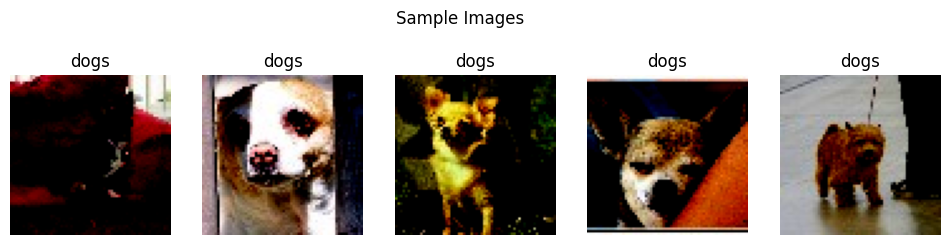

In [ ]:
sample_images, sample_labels = zip(*[dataset[i] for i in range(5)])
show_images(sample_images, sample_labels, "Sample Images")


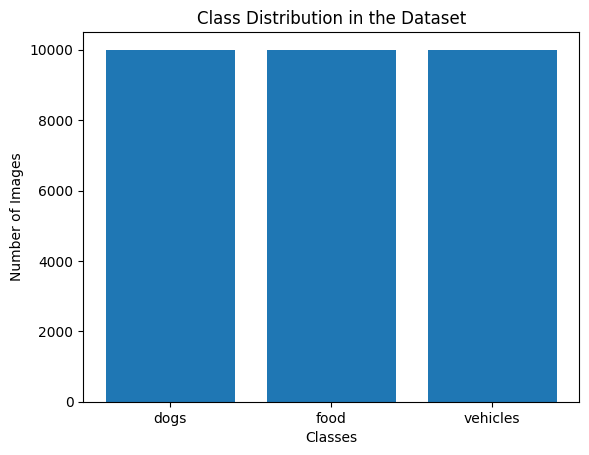

In [ ]:
class_counts = [0] * len(classes)
for _, label in dataset:
    class_counts[label] += 1

plt.bar(classes, class_counts)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in the Dataset')
plt.show()

In [ ]:
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Prepare DataLoader
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
print("Training set shape:", len(train_data))
print("Validation set shape:", len(val_data))
print("Test set shape:", len(test_data))

Training set shape: 24000
Validation set shape: 3000
Test set shape: 3000


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        identity = self.downsample(identity)

        out += identity
        out = self.relu(out)

        return out





In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
         # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # Residual layers
        self.layer1 = self.make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(BasicBlock, 512, 2, stride=2)
        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
      # Forward pass through the network
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x





In [ ]:
# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        # Iterate over training data
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate training accuracy and loss
        train_loss = running_train_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = correct_val / total_val
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(model.state_dict(), 'best_lstm_model.h5')

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch 1/10, Training Loss: 0.4368, Training Accuracy: 0.8221
Validation Loss: 0.0000, Validation Accuracy: 0.8530
Epoch 2/10, Training Loss: 0.2696, Training Accuracy: 0.8980
Validation Loss: 0.0000, Validation Accuracy: 0.9030
Epoch 3/10, Training Loss: 0.1960, Training Accuracy: 0.9247
Validation Loss: 0.0000, Validation Accuracy: 0.8933
Epoch 4/10, Training Loss: 0.1351, Training Accuracy: 0.9496
Validation Loss: 0.0000, Validation Accuracy: 0.9013
Epoch 5/10, Training Loss: 0.1043, Training Accuracy: 0.9603
Validation Loss: 0.0000, Validation Accuracy: 0.8853
Epoch 6/10, Training Loss: 0.0813, Training Accuracy: 0.9694
Validation Loss: 0.0000, Validation Accuracy: 0.8777
Epoch 7/10, Training Loss: 0.0481, Training Accuracy: 0.9830
Validation Loss: 0.0000, Validation Accuracy: 0.8747
Epoch 8/10, Training Loss: 0.0454, Training Accuracy: 0.9848
Validation Loss: 0.0000, Validation Accuracy: 0.8820
Epoch 9/10, Training Loss: 0.0379, Training Accuracy: 0.9867
Validation Loss: 0.0000, Va

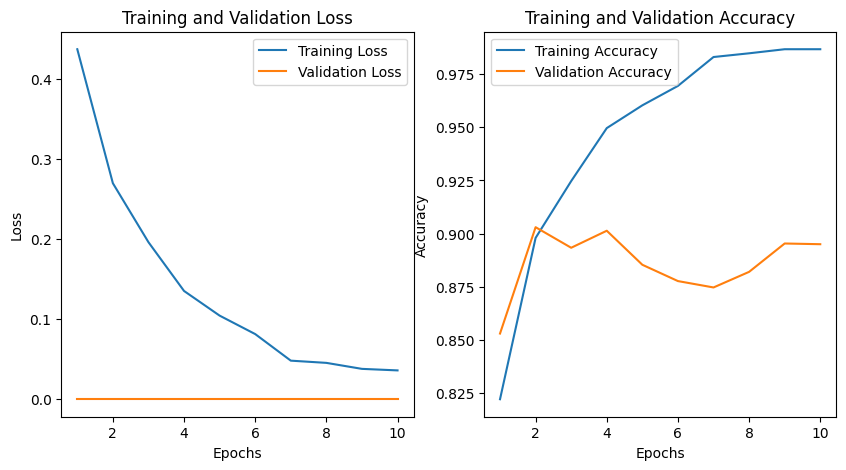

In [ ]:
# Plotting training and validation metrics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
model.eval()
running_test_loss = 0.0
correct_test = 0
total_test = 0
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
# Calculate test accuracy
test_loss = running_test_loss / len(test_loader.dataset)
test_acc = correct_test / total_test
print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_acc:.4f}")

Testing Loss: 0.4288, Testing Accuracy: 0.8923


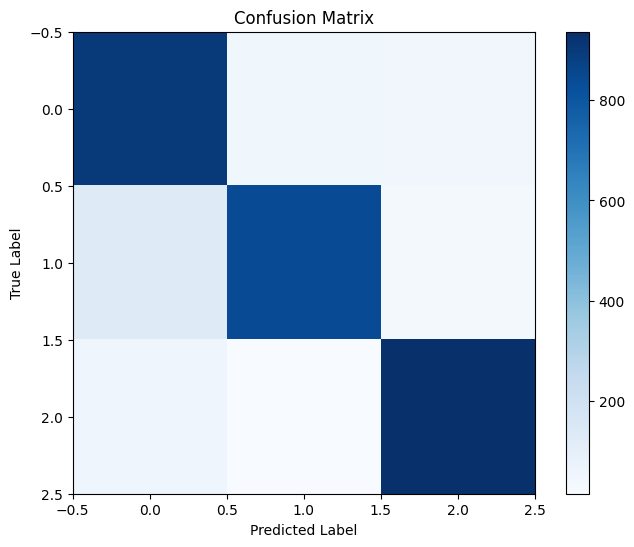

Classification Report:
              precision    recall  f1-score   support

        dogs       0.83      0.91      0.87       996
        food       0.93      0.84      0.88       999
    vehicles       0.92      0.93      0.93      1005

    accuracy                           0.89      3000
   macro avg       0.90      0.89      0.89      3000
weighted avg       0.90      0.89      0.89      3000



In [ ]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Other evaluation metrics
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=classes))

# Regularization

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(BasicBlock, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x





In [ ]:
# Training the model in 10 epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4) # Added weight decay
epochs = 10

for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # epoch_loss = running_loss / len(train_loader.dataset)
        train_loss = running_train_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train
        # print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch__loss:.4f}")
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = correct_val / total_val

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        # print(f"Validation Accuracy: {val_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch 1/10, Training Loss: 0.4363, Training Accuracy: 0.8242
Validation Loss: 0.0000, Validation Accuracy: 0.8543
Epoch 2/10, Training Loss: 0.2733, Training Accuracy: 0.8955
Validation Loss: 0.0000, Validation Accuracy: 0.8950
Epoch 3/10, Training Loss: 0.2046, Training Accuracy: 0.9243
Validation Loss: 0.0000, Validation Accuracy: 0.8467
Epoch 4/10, Training Loss: 0.1475, Training Accuracy: 0.9462
Validation Loss: 0.0000, Validation Accuracy: 0.8937
Epoch 5/10, Training Loss: 0.0991, Training Accuracy: 0.9629
Validation Loss: 0.0000, Validation Accuracy: 0.8937
Epoch 6/10, Training Loss: 0.0791, Training Accuracy: 0.9715
Validation Loss: 0.0000, Validation Accuracy: 0.8847
Epoch 7/10, Training Loss: 0.0646, Training Accuracy: 0.9762
Validation Loss: 0.0000, Validation Accuracy: 0.8823
Epoch 8/10, Training Loss: 0.0451, Training Accuracy: 0.9839
Validation Loss: 0.0000, Validation Accuracy: 0.8877
Epoch 9/10, Training Loss: 0.0392, Training Accuracy: 0.9855
Validation Loss: 0.0000, Va

In [ ]:
model.eval()
running_test_loss = 0.0
correct_test = 0
total_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss = running_test_loss / len(test_loader.dataset)
test_acc = correct_test / total_test
print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_acc:.4f}")

Testing Loss: 0.4263, Testing Accuracy: 0.8960


## Dropout

In [ ]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(BasicBlock, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x





In [ ]:
# Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 10

for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) #Move inputs and labels to the device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()  # Increment the number of correct predictions

        # epoch_loss = running_loss / len(train_loader.dataset)
        train_loss = running_train_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        # print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch__loss:.4f}")
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        # Calculate validation loss and accuracy
        val_loss = running_val_loss / len(val_loader.dataset)
        val_acc = correct_val / total_val

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        # print(f"Validation Accuracy: {val_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

Epoch 1/10, Training Loss: 0.4266, Training Accuracy: 0.8269
Validation Loss: 0.0000, Validation Accuracy: 0.8387
Epoch 2/10, Training Loss: 0.2735, Training Accuracy: 0.8976
Validation Loss: 0.0000, Validation Accuracy: 0.8857
Epoch 3/10, Training Loss: 0.2011, Training Accuracy: 0.9243
Validation Loss: 0.0000, Validation Accuracy: 0.8733
Epoch 4/10, Training Loss: 0.1387, Training Accuracy: 0.9492
Validation Loss: 0.0000, Validation Accuracy: 0.8920
Epoch 5/10, Training Loss: 0.1130, Training Accuracy: 0.9587
Validation Loss: 0.0000, Validation Accuracy: 0.9007
Epoch 6/10, Training Loss: 0.0740, Training Accuracy: 0.9734
Validation Loss: 0.0000, Validation Accuracy: 0.8750
Epoch 7/10, Training Loss: 0.0570, Training Accuracy: 0.9789
Validation Loss: 0.0000, Validation Accuracy: 0.8853
Epoch 8/10, Training Loss: 0.0485, Training Accuracy: 0.9828
Validation Loss: 0.0000, Validation Accuracy: 0.8593
Epoch 9/10, Training Loss: 0.0427, Training Accuracy: 0.9847
Validation Loss: 0.0000, Va

In [ ]:
model.eval()
running_test_loss = 0.0
correct_test = 0
total_test = 0
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

test_loss = running_test_loss / len(test_loader.dataset)
test_acc = correct_test / total_test
print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_acc:.4f}")

Testing Loss: 0.4561, Testing Accuracy: 0.8793


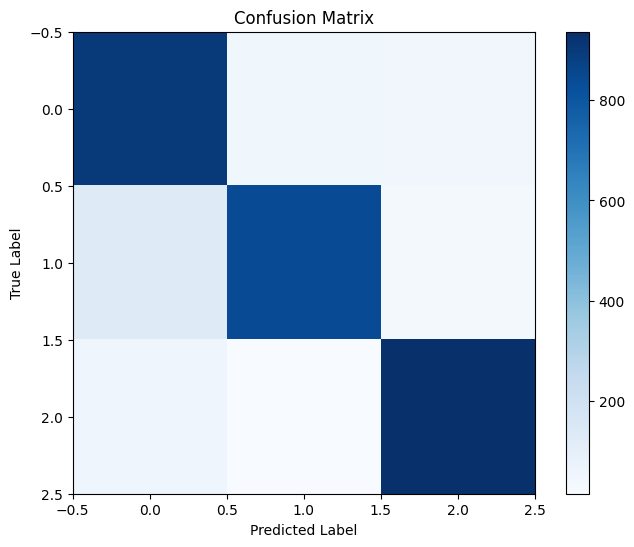

Classification Report:
              precision    recall  f1-score   support

        dogs       0.83      0.91      0.87       996
        food       0.93      0.84      0.88       999
    vehicles       0.92      0.93      0.93      1005

    accuracy                           0.89      3000
   macro avg       0.90      0.89      0.89      3000
weighted avg       0.90      0.89      0.89      3000



In [ ]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Other evaluation metrics
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=classes))